In [ ]:
%matplotlib notebook

# Imports
import random
import numpy as np
import itertools
from itertools import combinations
import h5py
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from keras.utils.vis_utils import plot_model
from keras.losses import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.ops import disable_eager_execution, enable_eager_execution
sys.path.append('./libraries/Keras-HDF5-ImageDataGenerator/')
from h5imagegenerator.generator import HDF5ImageGenerator
from albumentations import Compose, Crop, ToFloat, Normalize
sys.path.append('./libraries/Deep----Koopman/')
from Architecture import _transformer, _pred_K, linear_update, compute_aux_inputs, JacobianLayer
from scipy.stats import gaussian_kde
from scipy.integrate import odeint
from multiprocessing import Pool

#Initialise learning
%killbgscripts
import keras
from keras import backend as K
K.clear_session()
disable_eager_execution() # Needed for running custom loss
sns.set(font_scale=1)

#Fix the seed, for evaluation
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# B. Learning pendulum dynamics

In this notebook we follow on from the first tutorial (A. Pendulum dynamics outline) to explore learning the dynamics of a pendulum using a Koopman operator theory based deep learning approach. 

The examples here use the method created by [^fn1], and are run using a modified version of the Keras implementation from [^fn3]).

This notebook is primarily focused on presenting and analysing the spectral outputs (e.g. eigenfunctions) of the learnt model (the later sections of this notebook). To help elucidate these results, a modified implementation of [^fn3] is also included here. As the focus of this repository is on tutorials, technical/implementation details are secondary, and as such this code might not be able to run as is.

[^fn1]: Lusch, B., Kutz, J.N. & Brunton, S.L. Deep learning for universal linear embeddings of nonlinear dynamics. Nat Commun 9, 4950 (2018). https://doi.org/10.1038/s41467-018-07210-0

[^fn3]: https://github.com/dykuang/Deep----Koopman


# i) Creating the model

## Generate data

Firstly a dataset of pendulum swings should be generated. The notebook 'Generate pendulum data.ipynb' should be run, with the following control options:

- pendulum_type = 'rigid'
- control = False
- friction = 0

This will generate six datasets into the 'data' subdirectory:

- train/test/valid : Randomly generated trajectories of motion
- top/mid/bottom : Lengthy trajectories initialised at specific angles, to visualise different states

In [2]:
# Define the system to model
system = 'pendulum'  # Possible values: 'pendulum', 'quadratic', 'duffing'

In [3]:
if system == 'pendulum' or system == 'duffing':
    system_behaviour = 'oscilatory'
elif system == 'quadratic':
    system_behaviour = 'convergent'

In [4]:
# Variables for learning
BATCH_SIZE = 128
EPOCHS = 100

## Load the datasets

This code uses a modified version of the Keras-HDF5-ImageDataGenerator, where modifications perform augmentations of the output.

This modification included in this repository's libraries folder, and is also avaliable at https://gitlab.com/Brendan_Michael/Keras-HDF5-ImageDataGenerator


In [5]:
xmax_state = 2  # Number of state variables
num_control = 0 # Number of control variables
DATA_TIMESTEPS = 50

# Trim any extra timesteps
augmentor = Compose([
    Crop(x_min=0,  x_max=xmax_state,y_min=0,y_max=DATA_TIMESTEPS),
])
augmenter_labels = Compose([
    Crop(x_min=0,  x_max=xmax_state,y_min=0,y_max=DATA_TIMESTEPS),
])

# Set keys
X_key = 'state_time'
y_key = 'state_time_plus_1'
classes_key = 'state_time_plus_1'

# Define generators on the HDF5 files
# By using generators, we don't need to load all samples into memory at once. Its a bit slower, but it means we can used many more samples
# Define a generator where input is state at t, and output is state at t+1
train_generator = HDF5ImageGenerator(
        src = './data/train.hdf5',
        X_key=X_key,
        y_key=y_key,
        classes_key = classes_key,
        scaler=False, # This assumes inputs are [0,255] (standard images), and shouldn't be used. Instead normalise as explict layer
        labels_encoding=False, # this is fine, as its regression
        batch_size=BATCH_SIZE,
        mode='train',
        augmenter=augmentor,
        augmenter_labels = augmenter_labels, # also crop the outputs
        shuffle=True,
)

valid_generator = HDF5ImageGenerator(
        src='./data/valid.hdf5',
        X_key=X_key,
        y_key=y_key,
        classes_key = classes_key,
        scaler=False,
        labels_encoding=False,
        batch_size=BATCH_SIZE,
        mode='train',
        augmenter=augmentor,
        augmenter_labels = augmenter_labels, 
        shuffle=True,
)

test_generator = HDF5ImageGenerator(
        src='./data/test.hdf5',
        X_key=X_key,
        y_key=y_key,
        classes_key = classes_key,
        scaler=False,
        labels_encoding=False,
        batch_size=BATCH_SIZE,
        mode='train', 
        augmenter=augmentor,
        augmenter_labels = augmenter_labels, 
        shuffle=True,
)

EVALUATION_INTERVAL = len(train_generator._indices) // BATCH_SIZE
VALIDATION_STEPS = len(valid_generator._indices) // BATCH_SIZE


# Define generators for the long term data. This is used to compare against predictions made far into the future, and are not used for training.
NUM_DELAYS = 969

long_generator = HDF5ImageGenerator(
        src = './data/long_trajectories.hdf5',
        X_key=X_key,
        y_key=y_key,
        classes_key = classes_key,
        scaler=False, # This assumes inputs are [0,255] (standard images), and shouldn't be used. Instead normalise as explict layer
        labels_encoding=False, # this is fine, as its regression
        batch_size=NUM_DELAYS,
        mode='train',
        augmenter=augmentor,
        augmenter_labels = augmenter_labels, # also crop the outputs
        shuffle=True,
)
NUM_LONG_TRAJECTORIES = long_generator[0][0].shape[0]

### If the datasets are small enough, load training data into memory instead of generators to speed up learning

In [6]:
load_into_memory = True

In [7]:
if load_into_memory:
    filename = './data/train.hdf5'
    with h5py.File(filename, "r") as f:        
        train_input = f[list(f.keys())[0]][()]  # returns as a numpy array
        train_output = f[list(f.keys())[1]][()]  # returns as a numpy array

    filename = './data/valid.hdf5'
    with h5py.File(filename, "r") as f:    
        valid_input = f[list(f.keys())[0]][()]  # returns as a numpy array
        valid_output = f[list(f.keys())[1]][()]  # returns as a numpy array

    train_input = train_input[:,:,:xmax_state]
    train_output = train_output[:,:,:xmax_state]
    valid_input = valid_input[:,:,:xmax_state]
    valid_output = valid_output[:,:,:xmax_state]


# Visualise trajectories

The goal of learning the pendulum dynamics, is to create a model that allows us to predict future states given current observations. For example, the below image shows sample trajectories, where both the historical data and state is avaliable. The goal is to use that data, to predict what the next state will be.

Text(0.5, 1.0, 'State space')

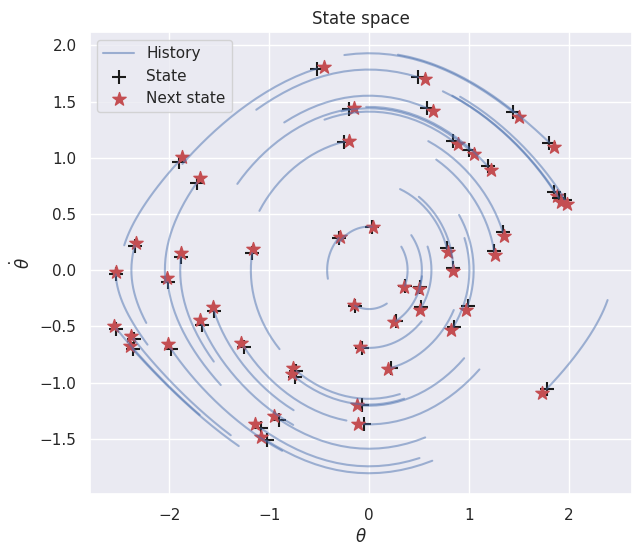

In [8]:
%matplotlib inline

fig = plt.figure(figsize=(7,6))
for i in range(50):
    plt.plot(train_generator[0][0][i,::3,0],train_generator[0][0][i,::3,1],color='b',alpha=0.5,label='History' if i==0 else '')
    plt.scatter(train_generator[0][1][i,-3,0],train_generator[0][1][i,-3,1],color='k',alpha=1,marker='+',s=100,label='State' if i==0 else '')
    plt.scatter(train_generator[0][1][i,-1,0],train_generator[0][1][i,-1,1],color='r',alpha=1,marker='*',s=100,label='Next state' if i==0 else '')
plt.legend(loc=2)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
plt.title('State space')

## Parameterisation

Network parameters are defined according to the Deep Koopman paper

In [9]:
'''
Adapted from https://github.com/dykuang/Deep----Koopman
'''
par = {
       'input steps':DATA_TIMESTEPS,
       'latent steps':DATA_TIMESTEPS,
       'output steps':DATA_TIMESTEPS,
       'pred steps': DATA_TIMESTEPS,
       'batch size': BATCH_SIZE,
       'en dim list': [80,80], # widths of encoder (two layers)
       'de dim list': [80,80], # widths of deencoder (two layers)
       'K reg': 10e-14,
       'epochs': EPOCHS,
       'hidden_widths_omega': [170], # the width of the auxiliary network (one layer)
       'lr': 0.001, 
       'alpha_1' : 0.001, 
        #'alpha_2' : 10e-9, # this is an infinity norm term, but its not used in the code
       'alpha_3' : 10e-14,
        'gamma' : 0.001, # an norm term for controlling the Jacobian loss
       'dt' : 0.02
       }

if system == 'pendulum':
    par['num complex'] = 1  # number of conjugate pairs (only one is needed for pendulum)
    par['num real']    = 0       
elif system == 'duffing':
    par['num complex'] = 1
    par['num real']    = 0    
elif system == 'quadratic':
    par['num complex'] = 0  
    par['num real']    = 2  # number of conjugate pairs (two real one is needed for quadtratic)
        
par['num_samples'], par['time steps'], par['input feature dim'] = train_generator[0][0].shape
par['num_samples'], par['time steps'], par['output feature dim'] = train_generator[0][1].shape
input_shape = (par['input steps'], par['input feature dim'])
output_shape = (par['input steps'], par['output feature dim'])

# Latent dimension
par['latent dim'] = 2*par['num complex'] + par['num real'] # Each complex number is a pair here, so number of dimensions = 2c+r
latent_shape = (par['latent steps'],)+ (par['latent dim'],)

# Define losses

In [10]:
'''
Adapted from https://github.com/dykuang/Deep----Koopman
Loss function is modified here to make it follow the method as outlined in [^fn1]
Specifically, here:
1. Mean squared error is used instead of absolute error
2. An alpha_1 variable is used to control between state loss and reconstruction loss
3. A next step reconstruction loss over m future steps is computed
'''

'''
Losses
'''
# The latent state transition loss: ||g(x') - K(G(x))|| 
# Enforces linearity by encouraging the autoencoder to learn a linear relationship between the encoded actual
# next state, and the next step prediction of the encoded current state.
# This focuses on the direct relationship between the encoded states and the linear dynamics
def State_loss(yTrue, yPred):
    return tf.reduce_mean(tf.math.squared_difference(encoder(yTrue),KGx))

# # Encourage sparsity when learning the number of eigenfunctions
# def State_loss(yTrue, yPred):
#     # Compute the sparse coefficients of the Koopman eigenfunctions
#     coeffs = tf.concat([tf.math.real(KGx), tf.math.imag(KGx)], axis=-1)
#     # Compute the sparsity penalty using L1 regularization
#     sparsity_penalty = tf.reduce_mean(tf.keras.backend.sum(tf.keras.backend.abs(coeffs), axis=0))
#     # Compute the MSE between the predicted and actual Koopman operator
#     mse_loss = tf.reduce_mean(tf.math.squared_difference(KGx, encoder(yTrue)))
#     # Return the sum of the MSE and sparsity penalties
#     return mse_loss + par['lambda']*sparsity_penalty

# The reconstruction loss: ||x - g^-1(G(x))||
def Rec_loss(yTrue, yPred):
    return tf.reduce_mean(tf.math.squared_difference(
        x_in[:,:,:xmax_state-num_control],
        decoded_x[:,:,:xmax_state-num_control]))

# The next step prediction loss || x' - G^-1(K(G(x))) || 
def Rec_plus1_loss(yTrue, yPred):
    return tf.reduce_mean(tf.math.squared_difference(
        yTrue[:,:,:xmax_state-num_control], # ignore control predictions
        yPred[:,:,:xmax_state-num_control]))

# The Jacobian loss
# Indirectly enforces linearity by  measuring the difference between the Jacobian of the learned dynamics
# and the identity matrix. If the learned dynamics are linear, the Jacobian should be a constant matrix. As
# this architecture is unfamiliar with the actual dynamics, the identity matrix is a reasonable choice.
# By minimizing this term, the model is encouraged to learn a linear relationship between the input and
# output of the learned dynamics. This focuses on the properties of the learned dynamics itself.
def Linearity_loss(yTrue, yPred):
    jacobian = jacobian_model(encoder(yTrue))
    identity_matrix = tf.eye(jacobian.shape[-1],batch_shape=jacobian.shape[0])
    L_jacobian = tf.reduce_mean(tf.math.squared_difference(jacobian, identity_matrix))
    return L_jacobian

def customLoss():
    # yTrue is the actual value X_t+1
    # yPred is the predicted reconstruction at X_t+1 (as this is the output of full_model, aka decoded_xp)
    # However, yPred is not actally needed when computing the (custom) loss, instead:
    # 1) L_recon is the MSE between X_t and the prediction of X_t
    # 2) L_pred is the MSE between X_t+m and the prediction of X_t+m, over m timesteps
    # 3) L_lin is the MSE between encoder(X_t+m) and the prediction of encoder(X_t+m), over m timesteps
    def Loss(yTrue, yPred):  
        L_recon = Rec_loss(yTrue, yPred)          # Reconstruction loss          
        L_pred = Rec_plus1_loss(yTrue, yPred)     # Next step state prediction loss             
        L_lin = State_loss(yTrue, yPred)          # Next step latent space prediction loss (linear loss)
        L_jacobian = Linearity_loss(yTrue, yPred) # Compute the Jacobian loss

        return  ((par['alpha_1']  * (L_recon+L_pred)) + L_lin) + par['gamma']*L_jacobian
    return Loss

# Training a model

To create a predictive model, the Deep Koopman network uses an encoder/decoder structure, with an inner latent layer learning the linear dynamics. Specifically, the inner layers learn Koopman eigenfunctions, and linear updates via eigenvalue growths and oscillations. See [^fn1] for details.

In [ ]:
'''
Adapted from https://github.com/dykuang/Deep----Koopman
Architecture is modified here to make it follow the method as outlined in [^fn1]
Specifically, here:
1. LSTM layers are replaced with a dense network for the encoder/decoder. LSTMs were never part of the original Deep Koopman paper, and add extra complexity. It is also not clear what effect recurrent nodes has on eigenfunction analysis.
2. Regularizers are added following the Deep Koopman paper
3. Conv1D layers are replaced with a dense network for the hidden widths. Conv1D layers were never part of the original Deep Koopman paper, and it unclear the effect convolution has.
4. linear_update remains mostly the same, but timesteps are computed independently to allow for a control signal to be passed.
'''

'''
Input
'''
x_in = Input(input_shape)   

'''
Encoder
Note: historical measurements asre appended into a vector, following Taken's embedding theorem
This is commonly applied in DMD/Koopman-like implementations.
'''    
x_reshape = tf.keras.layers.Reshape((1,np.prod(x_in.shape[1:])))(x_in)
Gx = _transformer(x_reshape, par['latent dim'], par['en dim list'],par['alpha_3'],activation_out='linear')
Gx = tf.reshape(Gx,(-1,par['latent dim']))
encoder = Model(x_in, Gx,name="encoder")

'''
linear update in latent space: Predicting via Koopman eigenvalues
'''
CR = compute_aux_inputs(par['num complex'], par['num real'])#compute the auxiliary inputs (complex coordinates are converted to magnitude)
Gx_CR = CR(Gx)
Koop = _pred_K(Gx_CR, par['num complex'], par['num real'],par['hidden_widths_omega'], par['K reg'],par['alpha_3'],activation_out='linear')
LU = linear_update(output_dim = Gx.shape, num_complex = par['num complex'], num_real = par['num real'],dt=par['dt'])
KGx = LU([Gx, Koop])
Knet = Model(x_in, [Koop, KGx]) 

'''
Decoder
'''
decoder_input = Input(shape = Gx.shape[1:])
decoded = _transformer(decoder_input, np.prod(output_shape), par['de dim list'],par['alpha_3'], activation_out='linear')
decoded =  tf.keras.layers.Reshape((x_in.shape[1:]))(decoded) # Reshape back into history
_decoder = Model(decoder_input, decoded,name="decoder")

'''
Outputs
'''
decoded_x = _decoder(Gx)   # Reconstruction of state input
decoded_xp = _decoder(KGx) # Prediction of next step state

'''
Full model
'''
full_model = Model(x_in, decoded_xp)

'''
Custom Koopman network with input: y_t, and output: y_t+1
In contrast to standard Knet defined above, which takes: input x_t and output: y_t+1 
'''
# Disassemble layers
layers = [l for l in Knet.layers]

# Create a new layer thats the latent input (y_t), instead of the state (x_t)
latent_input = Input(shape = Gx.shape[1:])

# starting layer (after the encoder)
s_layer = len(encoder.layers)

Koop_l = latent_input
# Add the remaining layers, ignoring the LU
for i in range(s_layer,len(layers)-1):
    Koop_l = layers[i] (Koop_l)

# Define new linear update
KGx_l = LU([latent_input, Koop_l])
custom_Knet = Model(latent_input, [Koop_l, KGx_l],name="Koopman_network")

# Model for computing the Jacobian of the latent dynamics
jacobian_input = Input(shape=Gx.shape[1:])
jacobian_layer = JacobianLayer(custom_Knet)(jacobian_input)
jacobian_model = Model(jacobian_input, jacobian_layer, name="jacobian_model")

In [ ]:
'''
Models
'''
print(encoder.summary())
print(custom_Knet.summary())
print(_decoder.summary())

## Visualise the full model

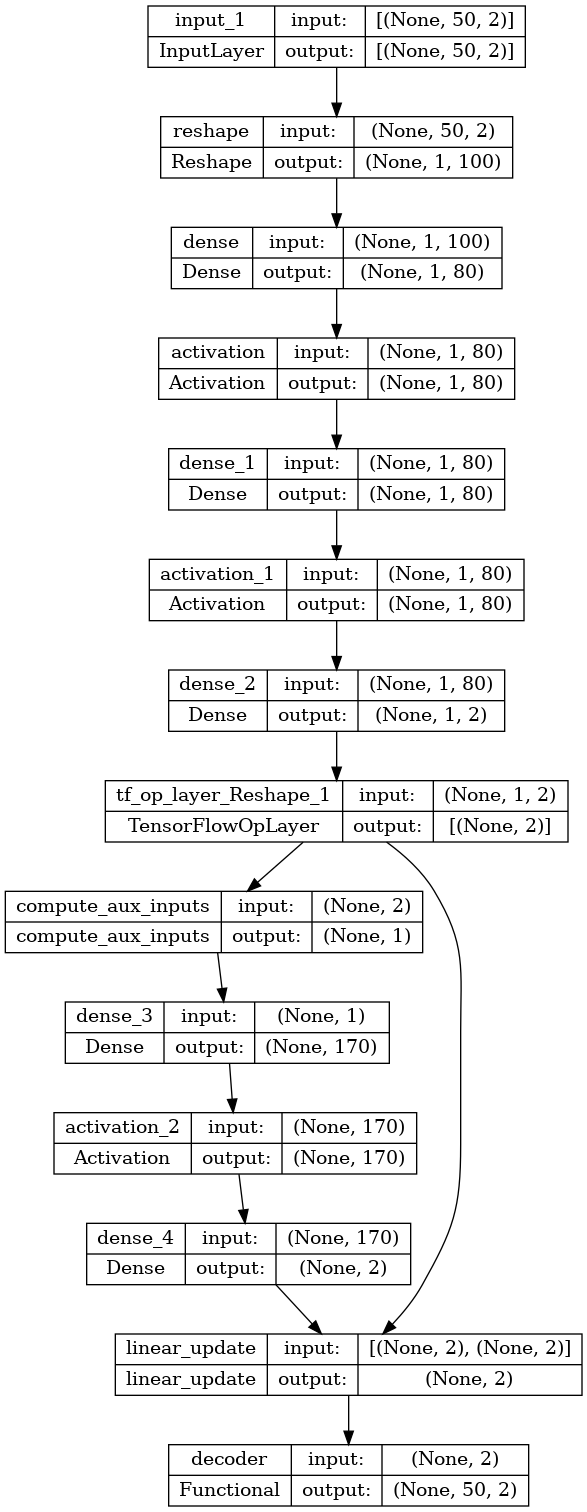

In [13]:
plot_model(full_model, show_shapes=True, show_layer_names=True)

## Train the model

In [ ]:
optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = par['lr'],decay = par['lr']/par['epochs'])

full_model.compile(loss=customLoss(),
                    metrics=[State_loss, Rec_loss,Rec_plus1_loss,Linearity_loss
                            ],
                   optimizer=optimizer,
                  )

if load_into_memory:
    history = full_model.fit(x=train_input,y=train_output,epochs = EPOCHS, verbose=1,
                    validation_data=(valid_input,valid_output),
                    validation_steps=VALIDATION_STEPS,                     
                    batch_size=BATCH_SIZE,
                   )
    
else:
    history = full_model.fit(train_generator,epochs = EPOCHS, verbose=1,
                    validation_data=valid_generator,
                    validation_steps=VALIDATION_STEPS,
                    steps_per_epoch=EVALUATION_INTERVAL,
                   )
history = history.history

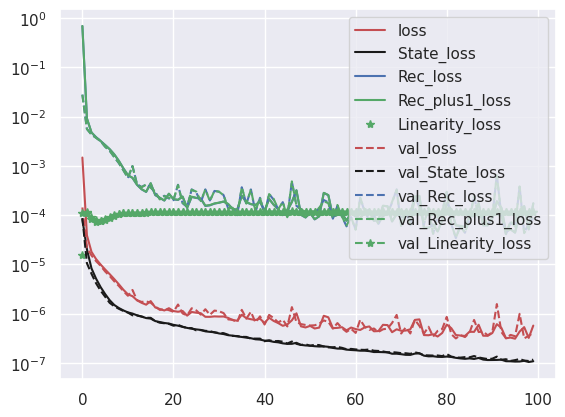

In [15]:
# training loss

plt.figure()
plt.plot((history['loss']), 'r')
plt.plot((history['State_loss']),'k')
plt.plot((history['Rec_loss']), 'b')
plt.plot((history['Rec_plus1_loss']), 'g')
plt.plot((history['Linearity_loss']), '*g')

plt.plot((history['val_loss']), '--r')
plt.plot((history['val_State_loss']),'--k')
plt.plot((history['val_Rec_loss']), '--b')
plt.plot((history['val_Rec_plus1_loss']), '--g')
plt.plot((history['val_Linearity_loss']), '*--g')


plt.legend(['loss','State_loss','Rec_loss', 'Rec_plus1_loss','Linearity_loss',
            'val_loss', 'val_State_loss','val_Rec_loss','val_Rec_plus1_loss','val_Linearity_loss'
           ])
plt.yscale('log')

# ii) Analyse the learnt dynamics model

Given this learnt model, the special components will be examined to determine if the model has captured physicaly-relevant components of the dynamical system.

## Visualise the learnt next step prediction

Examinging the next step prediction shows that the model can successfully predict future timesteps.

Text(0, 0.5, '$\\dot{\\theta}$')

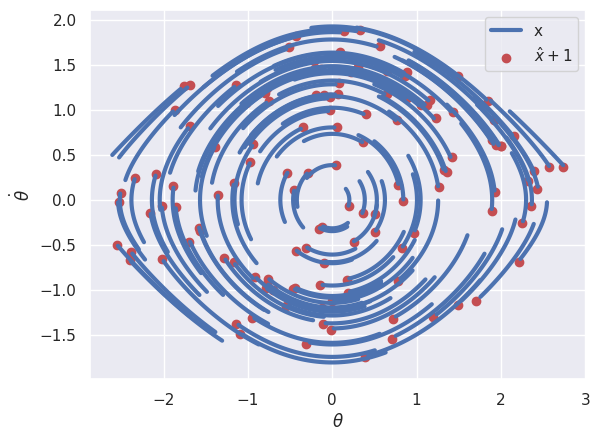

In [89]:
xhat_tp1 = full_model.predict(train_generator[0][0],verbose = 0)
fig = plt.figure()
for j,i in enumerate(range(128)):
    plt.plot(train_generator[0][0][i,:,0],train_generator[0][0][i,:,1],color='b', label = 'x' if j == 0 else "",linewidth=3)
    plt.scatter(xhat_tp1[i,-1,0],xhat_tp1[i,-1,1],color='r', label = r'$\hat{x}+1$' if j == 0 else "")
plt.legend()
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')

# Characterising outputs

Long-term predictions can be made with this model, but key to Deep Koopman is that the model contains spectral components that characterise the actual physical behaviour. It is not good enough to make accurate predictions, these predictions needs to be explainable in the context of dynamical systems.

To explore this, the following diagram displays outputs of the learnt model, mapped onto phase space, latent space, or time series. Following the diagram, a brief explaination of each subplot is given.

In [ ]:
# Compute outputs for training data
train_data_eigenvalues, train_data_latent = Knet.predict(train_input, verbose=0)
latent_space_jacobians = jacobian_model.predict(train_data_latent)

# Due to how imaginary eigenvalues are computed for complex eigenfunctions, oscillations can have positive or 
# negative values. This does not affect computation and is merely a quirk, so the absolute value is taken
# here to make later diagrams more intuative.
if system_behaviour == 'oscilatory':
    train_data_eigenvalues[:,:2*par['num complex']][:,1::2] =np.abs(train_data_eigenvalues[:,:2*par['num complex']][:,1::2])

In [18]:
# Load the data in the long samples into memory for easy of computation in plotting
with h5py.File('./data/long_trajectories.hdf5', 'r') as f:
    long_data_list = f[list(f.keys())[0]][()][:, :,:, :xmax_state]
long_data_latent_list = []
long_data_eigenvalues_list = []
long_data_jacobians_list = []
for i in range(NUM_LONG_TRAJECTORIES):
    long_data_eigenvalues, long_data_latent = Knet.predict(long_data_list[i], verbose=0)
    long_data_jacobians = jacobian_model.predict(long_data_latent)
    long_data_latent_list.append(long_data_latent)
    long_data_eigenvalues_list.append(long_data_eigenvalues)
    long_data_jacobians_list.append(long_data_jacobians)
long_data_latent_list = np.array(long_data_latent_list)
long_data_eigenvalues_list = np.array(long_data_eigenvalues_list)
long_data_jacobians_list = np.array(long_data_jacobians_list)

# Imaginary eigenvalues for complex eigenfunctions can have positive or negative values,
# which is a quirk that does not affect computation.
# To make diagrams more intuitive, we take the absolute value
if system_behaviour == 'oscilatory':
    long_data_eigenvalues_list[:,:,:2*par['num complex']][:,:,1::2] =np.abs(long_data_eigenvalues_list[:,:,:2*par['num complex']][:,:,1::2])
    long_data_eigenvalues_list[:,:,:2*par['num complex']][:,:,1::2] =np.abs(long_data_eigenvalues_list[:,:,:2*par['num complex']][:,:,1::2])
    long_data_eigenvalues_list[:,:,:2*par['num complex']][:,:,1::2] =np.abs(long_data_eigenvalues_list[:,:,:2*par['num complex']][:,:,1::2])

The following plots examine the dynamics of the learnt system:
    
   
| Subplot | Description |
|:--------:|:------|
| A)     | Phase space - The relationship between the position and velocity of the system. This gives insights into the periodicity, stability, and attractors of the system. |
| B)     | Latent space - The lower-dimensional representation of the system's dynamics. This reveals the underlying linear structure and patterns. |
| C)     | Mapping of the real part of the system's eigenfunction to the phase space. This shows the spatial distribution of the eigenfunction and reveals the system's modes of oscillation and their spatial patterns |
| D)     | Mapping of the trace of the Jacobian of the learned network with respect to the latent space coordinates -  shows the rate of expansion or contraction of nearby trajectories in the latent space, revealing the stability of the system's dynamics. Note positive trace values indicate expansion of nearby trajectories, potentially leading to chaotic behavior, while negative trace values indicate contraction of nearby trajectories, potentially leading to stable behavior. |
| E)     | Mapping of the imaginary part of the system's eigenfunction to the phase space shows the spatial distribution of the eigenfunction's phase. It can reveal the system's phase relations and synchronization patterns. |
| F)     | Distribution of latent representations |
| G)     | Mapping of the real part of the system's eigenvalue to the phase space, reveals the system's stability and the nature of the attractors. |
| H)     | Mapping of the real part of the system's eigenvalue to the latent space |
| I)     | Mapping of the imaginary part of the system's eigenvalue to the phase space, shows the system's oscillatory behavior. |
| J)     | Mapping of the imaginary part of the system's eigenvalue to the latent space |
| K)     | Mapping of the magnitude of the eigenfunctions to the phase space - According to Lusch (2018) this is proportional to the system's Hamiltonian (i.e. magnitudes trace level sets of the Hamiltonian) which is the total energy of the system as the sum of kinetic and potential energies. In this, the magnitude is the sum over all eigenfunctions (not just the real and imaginary components of one at a time), as Koopman operator theory assumes that the eigenfunctions can be complex exponentials and can be combined to create real-valued functions. Therefore, it makes sense to compute the Hamiltonian energy using all the components of the eigenfunctions, as they jointly describe the energy structure of the system. Computing two separate Hamiltonian energies would not be consistent with the theory and could lead to an inaccurate representation of the underlying dynamics. |
| L)     | Mapping of the magnitude of the eigenfunctions to the latent space - the total energy of the system as the sum of kinetic and potential energies. |
| M)     | Plot of the example trajectories energy as a function of time |
| N)     | Plot of the example trajectories trace of their Jacobian as a function of time |
| O)     | Plot of the example trajectories growth/decay as a function of time |
| P)     | Plot of the example trajectories frequency as a function of time |

In [19]:
def make_2D_plots(eigenfunction_num_1,eigenfunction_num_2):
    # For some plots, use a smaller subset of the data
    batch, num_samples = 0, 50
    cmap = 'viridis' # viridis plasma
    
    # Define figure
    params = {'oscilatory': {'figsize': (30, 10), 'nrows': 2, 'ncols': 10},
              'convergent': {'figsize': (9, 5), 'nrows': 2, 'ncols': 3}}
    fig = plt.figure(figsize=params[system_behaviour]['figsize'], constrained_layout=True)
    gs = GridSpec(params[system_behaviour]['nrows'], params[system_behaviour]['ncols'], figure=fig)
    # Plot the phase/latent trajectories and highlighted trajectories in subplots
    titles = ['A) Phase space (x)',
              'B) Latent space (y)',
              "C) {} $\mapsto$ phase".format(r'$\phi_\mathbb{R}$' if system_behaviour == 'oscilatory' else r'$\phi_1$'),
              "D) $Tr(J(K))\mapsto$ latent",
              "E) {} $\mapsto$ phase".format(r'$\phi_\mathbb{I}$' if system_behaviour == 'oscilatory' else r'$\phi_2$'),
              "F) Distribution of latent", 
              "G) {} $\mapsto$ phase".format(r'$\mu$' if system_behaviour == 'oscilatory' else r'$\lambda_1$'),
              "H) {} $\mapsto$ latent".format(r'$\mu$' if system_behaviour == 'oscilatory' else r'$\lambda_1$'),
              "I) {} $\mapsto$ phase".format(r'$\omega$' if system_behaviour == 'oscilatory' else r'$\lambda_2$'),
              "J) {} $\mapsto$ latent".format(r'$\omega$' if system_behaviour == 'oscilatory' else r'$\lambda_2$'),
              "K) $H(y) ≈ α * (|y|^2) \mapsto$ phase",
              "L) $H(y) ≈ α * (|y|^2)\mapsto$ latent",
              "M) $H(y) ≈ α * \phi_\mathbb{R}^2 + \phi_\mathbb{I}^2 $",
              "",
              "",
              "N) $Tr(J(K))",
              "O) $\mu$ (growth)",
              "P) $\omega$ (frequency)"
             ]
    combinations = itertools.product(range(params[system_behaviour]['ncols']), range(params[system_behaviour]['nrows']))
    for i, (title,(column,row)) in enumerate(zip(titles,combinations)):        
        # Create axes
        # Create for all of the phase/latent space
        if column < 6:
            ax = fig.add_subplot(gs[row, column])
            ax.set_xlabel(r'$q$' if i == 0 else r'$\phi_\mathbb{R}$')
            ax.set_ylabel(r'$\dot{q}$' if i == 0 else r'$\phi_\mathbb{I}$')
        # Create for the timeseries
        elif (column == 6) or (column == 8):
            ax = fig.add_subplot(gs[row, column:column+2])
            ax.set_xlabel(r'$t$')
        ax.set_title(title)

        
        #Plot background phase trajectories for the first cell
        if row == 0 and column==0:
            for i in range(num_samples):
                ax.plot(train_input[i, :, 0], train_input[i, :, 1], 'b', alpha=0.5)
            #ax.legend(ncol=1, loc='upper right')
            
        # For all columns not the time plots
        if column < 6:
            # Plot trajectories and highlighted trajectories on each
            for data in [x for x in long_data_list] if row == 0 else long_data_latent_list:
                ax.plot(data[:, -1, 0] if row == 0 else data[:, eigenfunction_num_1], 
                        data[:, -1, 1] if row == 0 else data[:, eigenfunction_num_2])
            
            # Ignoring the first plot
            if column > 0:
                # Plot the scatter map with colors for each variable
                if row == 0:
                    if column == 1:   # If Real -> Phase
                        c = train_data_latent[:, eigenfunction_num_1]
                    elif column == 2: # If Imag -> Phase
                        c = train_data_latent[:, eigenfunction_num_2]
                    elif column == 3: # If mu -> phase
                        c = train_data_eigenvalues[:, eigenfunction_num_1]
                    elif column == 4: # If omega -> Phase
                        c = train_data_eigenvalues[:, eigenfunction_num_2]
                    elif column == 5: # If Hamiltonian
                        c = np.sum(train_data_latent ** 2, axis=1)                    
                    x, y = train_input[:, -1, :2].T
                else:
                    if column == 1:     # If divergence -> Phase
                        c = np.trace(latent_space_jacobians, axis1=1, axis2=2)
                    elif column == 2: # Distribution of points
                        kde = gaussian_kde(train_data_latent.T)
                        c = kde(train_data_latent.T)
                    elif column == 3: # If mu -> latent
                        c = train_data_eigenvalues[:, eigenfunction_num_1]
                    elif column == 4: # # If omega -> latent
                        c = train_data_eigenvalues[:, eigenfunction_num_2] 
                    elif column == 5: # If Hamiltonian
                        c = np.sum(train_data_latent ** 2, axis=1)
                    x, y = train_data_latent[:, [eigenfunction_num_1, eigenfunction_num_2]].T
                
                sc = ax.scatter(x, y, c=c, cmap=cmap, marker='.')
                cbar = plt.colorbar(sc, orientation='horizontal')
        # For the first time series plots (energy and trace)
        elif column == 6:
            # If we're on the first row, plot energy data
            if row == 0:
                # Calculate the energy of each system using the sum of the squares of all eigenfunctions
                colour_list = [np.sum(x**2,axis=1) for x in long_data_latent_list]
                
            # If we're on the second row, plot the linearness
            elif row == 1:
                # Take the trace of each system
                colour_list = long_data_jacobians_trace_list = [np.trace(x, axis1=1, axis2=2) for x in long_data_jacobians_list]

            # Loop through each system's data and corresponding latent values
            for i,colour_var in enumerate(colour_list):
                ax.scatter(range(long_data_list.shape[1]), long_data_list[i,:,-1,0],
                           c=colour_var,
                           vmin=np.min(colour_list), vmax=np.max(colour_list),
                           cmap=cmap)
            sc = ax.collections[-1]  # get the last scatter plot
            cbar = plt.colorbar(sc, orientation='horizontal')

        # For the second time series plots (mu and omega)
        elif column == 8:
            if row == 0:
                # Take the real eigenvalue
                colour_list = long_data_eigenvalues_real_eig_list = [x for x in long_data_eigenvalues_list[:,:, eigenfunction_num_1]]
            # If we're on the second row, plot frequency data
            elif row == 1:
                # Take the frequency of each system
                colour_list = long_data_eigenvalues_imag_eig_list = [x for x in long_data_eigenvalues_list[:,:, eigenfunction_num_2]]
            # Loop through each system's data and corresponding latent values
            for i,colour_var in enumerate(colour_list):
                ax.scatter(range(long_data_list.shape[1]), long_data_list[i,:,-1,0],
                           c=colour_var,
                           vmin=np.min(colour_list), vmax=np.max(colour_list),
                           cmap=cmap,
                          )
            sc = ax.collections[-1]  # get the last scatter plot
            cbar = plt.colorbar(sc, orientation='horizontal')


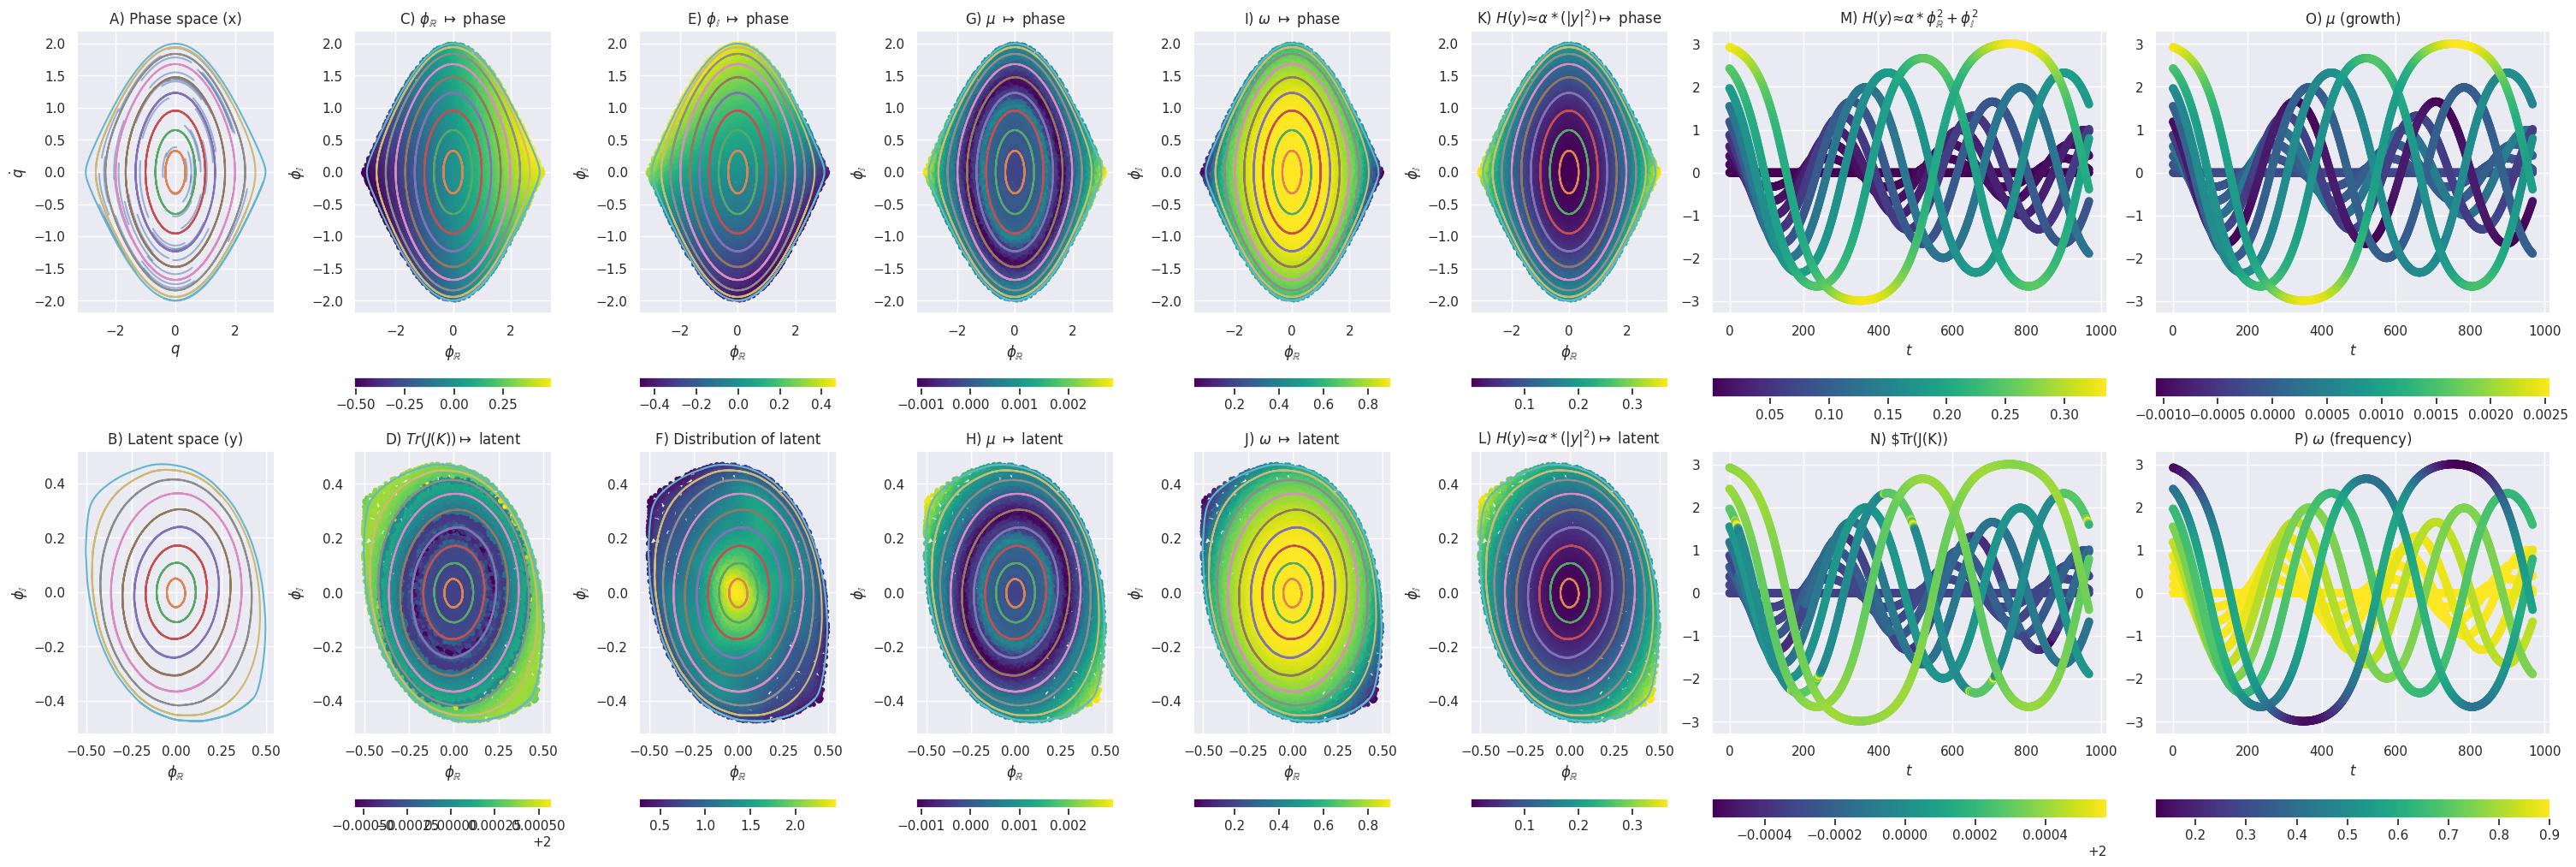

In [20]:
# Plot every complex eigenfunction
for i in range(0,2*par['num complex'],2):
    make_2D_plots(i,i+1)       

In [21]:
# Plot every pair of real eigenfunctions
if par['num real'] == 1:
    print('Can\'t plot single real eigenfunctions yet')
else:
    combinations_list = list(combinations(range(par['num real']), 2))
    for i in combinations_list:
        make_2D_plots(2*par['num complex']+i[0],2*par['num complex']+i[1])   

# Analysis:

Please see the following paper for a more detailed analysis of this problem:

[^fn0]: Komeno, Naoto, Brendan Michael, Katharina Küchler, Edgar Anarossi, and Takamitsu Matsubara. "Deep Koopman with Control: Spectral Analysis of Soft Robot Dynamics." 2022 61st Annual Conference of the Society of Instrument and Control Engineers (SICE). IEEE, 2022. https://ieeexplore.ieee.org/abstract/document/9905758/
[^fn00]: https://arxiv.org/pdf/2210.07563.pdf

## Explainations:

A) State (phase) space of the problem. A set of trajectories are presented

B) Latent space. Trajectories in the phase space are mapped via a single complex conjugate pair of learnt eigenfunctions (D and E), to a latent-space that is linear in polar coordinates, the system is therefore globally linearised within the Koopman framework.

E) Growths/decays of the eigenvalues are small (G and H). This is to be expected, as this system does not experience growth/decay. 

F) Frequency of the eigenvalues varies across the latent space. As such, by using the auxiliary network inside the Koopman network to parameterise the learnt dynamics by a continuous spectra of eigenvalues, a continuous range of oscillatory frequencies is also captured by the model. This is seen in I), where the continuous spectra captures an intuitive physical characteristic of the pendulum, that being the frequency of oscillation is dependent on the position in the phase space (eigenvalue frequency decreases the further from the centre, i.e., the period of the swing increases the further from the stable equilibrium position. In the context of the pendulum, this expressed as a high frequency oscillation at small angles, and low frequency oscillation at higher angles

# Further analysis 

## 1) Visualising the phase space

The primary focus of learning a Deep Koopman architecture, is to learn a linearisation of the latent space. This following section examines the linearness of both the input phase space, and the learnt latent dynamics.

First, a measure of the linearness is given. The linearness of the input space is computed by taking the deviation of the Jacobian of the linear region, against the known state-equations. This is a measure of how well the motion of the system can be approximated by a linear system. Specifically, this code takes the Jacobian of the region of the phase space where the dynamics are linear (i.e. small angle approximation), and takes the difference between that and the actual non-linear dynamics of the pendulum (i.e. [qdot,-g/l*sin*(q)]). This value then allows us to see which regions are linear. This is refered to as the Jacobian of the phase space, even though it is only for the linear region.

The second function examines how much the Jacobian of the learnt (hopefully linear) space deviates from the identity matrix, as such, how much the latent data changes when transformed by the Jacobian. This gives a measure of how linear the latent space is.

### 1.1) Show the stability and linearness of the phase space

Firstly, lets look at the phase space. 

To find the linearness, we take the Jacobian of the linear region of the pendulum, and find the deviation between that and the state equations.

In [22]:
from systems.dynamics_functions import pendulum_dynamics, duffing_oscillator, quadratic_attracting_manifold_dynamics
from systems.models import model_pendulum, model_duffing_oscillator, model_quadratic_attracting_manifold

if system == 'pendulum':
    model = model_pendulum()
    def state_system(x, t):
        return pendulum_dynamics(x, 0, model)
elif system == 'duffing':
    model = model_duffing_oscillator()
    def state_system(x, t):
        return duffing_oscillator(x, 0, 0, model)
elif system == 'quadratic':
    model = model_quadratic_attracting_manifold
    def state_system(x, t):
        return quadratic_attracting_manifold_dynamics(x, 0, model)

In [23]:
def state_jacobian(f, x, epsilon=1e-8):
    """
    Approximates the Jacobian of a dynamical system using finite differences.
    
    Parameters:
    - f: a function representing the system's equations, taking a state vector as input
    and returning a vector of the same shape
    - x: the current state vector
    - epsilon: the perturbation size for each variable
    
    Returns:
    A numpy array representing the Jacobian matrix
    """
    n = x.shape[-1]
    J = np.zeros(x.shape + (n,))
    for j in range(n):
        x_plus = np.copy(x)
        x_plus[...,j] += epsilon
        x_minus = np.copy(x)
        x_minus[...,j] -= epsilon
        f_plus = np.array(f(x_plus,0))
        f_minus = np.array(f(x_minus,0))
        J[...,j] = (f_plus - f_minus) / (2 * epsilon)
    return J

def compute_state_linearness(X):
    """
    Computes an estimate of the linearity of a dynamical system at a given state.

    Parameters
    ----------
    X : array_like, shape (N,2)
        State of the system at which to compute the linearity, where X[:,0] is the
        position and X[:,1] is the velocity.

    Returns
    -------
    squared_deviation : array_like, shape (N,2)
        Squared deviation of the numerical estimate of the Jacobian from the true
        state derivative.
    jacobians : array_like, shape (N,2,2)
        Numerical estimate of the Jacobian at the given state.
    rms_deviation : array_like, shape (N,)
        Root mean squared deviation of the numerical estimate of the state derivative
        from the true state derivative, computed using the estimated Jacobian.
    """
    jacobians = state_jacobian(state_system, X)
    Xdot = state_system(X,None)
    Xdot = Xdot.reshape((Xdot.shape[0] * Xdot.shape[1], Xdot.shape[2]))
    squared_deviation = np.square(np.einsum('ijk,ik->ij',jacobians.reshape(-1, 2, 2), X.reshape(-1, X.shape[2])) - Xdot)
    rms_deviation = np.sqrt(np.mean(squared_deviation, axis=1))
    rms_deviation = rms_deviation.reshape(X.shape[:2])
    squared_deviation = squared_deviation.reshape(X.shape)
    return squared_deviation, jacobians, rms_deviation

In [24]:
# Compute the Jacobians and a linearness measure
phase_space_normalized_deviations, phase_space_jacobians, phase_space_linearness = compute_state_linearness(train_input)

# compute the distance of the state to (0,0), and use this as the color for the corresponding eigenvalue
distances = np.sqrt(np.sum(train_input[:,-1,:]**2, axis=1))

# Compute eigenvalues and spectral radii of Jacobians for phase and latent spaces
# Jacobian of the whole system contains cross-terms between eigenfunctions
phase_eigenvalues_list = np.array([np.linalg.eig(jacobian)[0] for jacobian in phase_space_jacobians])
phase_spectral_radii = np.array([np.max(np.abs(eigenvalues)) for eigenvalues in phase_eigenvalues_list])

We can visualise this to see the following:

| Subplot | Description |
|:--------:|:------|
| A)     | **Linearity of the phase space (RMS)** - This subplot shows the RMS deviation between the Jacobian of the linear region, and the state dynamics, indicating the regions of linearity in the system. A more linear system will have lower RMS deviation, while a more nonlinear system will have higher RMS deviation. In this we can see that lower angles have little deviation, but the degree of non-linearity increases sharply at higher angles |
| B)     | **Stability of phase space** - This subplot shows spectral radius of the eigenvalues of the Jacobian. In the context of the pendulum, we can expect the system to have two fixed points $(0,0)$, and $(\pi,0)$, where the eigenvalues of the Jacobian at these points has magnitude 1, and as such are neutrally stable, and solutions oscillate around this but don't converge. Generally, if the spectral radii are $<1$, the fixed point is stable, and nearly trajectories converge to the fixed point. If the spectral radii are $>1$ trajectories diverge away from the fixed points. If the spectral radii are $=1$ this is more complex behaviours such as limit cycles.
| C)     | **Real eigenvalues of Jacobian Matrices (eigenvalue 1)** - This subplot shows the real eigenvalues of the Jacobian matrices at each point in the phase space. The real part of each eigenvalue represents the rate at which a small perturbation in the system will grow or decay over time in the corresponding eigenvector direction. If it is negative, the perturbation will decay over time and the system is locally stable in that direction. If the real part is positive, the perturbation will grow over time and the system is locally unstable in that direction. The direction associated with each eigenvalue is important, as the overall stability of the system depends on the combination of these directions. Higher angles may exhibit positive real eigenvalues due to the presence of unstable fixed points or periodic orbits caused by the flatness of the potential energy near angles close to $\pi$ or $-\pi$. A zero real part corresponds to a center, saddle-center or degenerate node, which explains the stable orbits seen in the plots.|
| D)     | **Imaginary eigenvalues of Jacobian Matrices (eigenvalue 1)** - This subplot shows the imaginary eigenvalues of the linearized Jacobian matrices at each point in the phase space. The imaginary part of each eigenvalue represents the rate at which a small perturbation in the system will oscillate or rotate around the corresponding eigenvector direction. If the imaginary part is nonzero, the system is oscillatory in that direction, while if it is zero, the system is non-oscillatory in that direction. The direction associated with each eigenvalue is important, as it determines the direction of oscillation or rotation of the perturbation. In this case, it is observed that the Jacobians of the lower angles display no oscillation, while other regions may display different types and directions of oscillations depending on the properties of the system at each point in the phase space. |
| E)     | **Real eigenvalues of Jacobian Matrices (eigenvalue 2)** - Similar to the above, but in the direction of the second eigenvector |
| F)     | **Imaginary eigenvalues of Jacobian Matrices (eigenvalue 2)** -Similar to the above, but in the direction of the second eigenvector | 
| G)     | **Complex eigenvalues of Jacobian Matrices** - This subplot shows the complex eigenvalues (eigenvalue 1 in viridis, eigenvalue 2 in plasma) of the linearized Jacobian matrices at each point in the phase space, indicating the stability and oscillatory behavior of the system. A stable and non-oscillatory system will have all eigenvalues with negative real parts and zero imaginary parts, while a stable and oscillatory system will have all eigenvalues with negative real parts and nonzero imaginary parts. An unstable system will have at least one eigenvalue with positive real part. This relates to dynamical systems analysis as it provides insight into the stability and oscillatory behavior of the system. |
| H)     | **Phase Space Linearity and Stability** - This subplot shows the RMS deviation against the spectral radius of the eigenvalues of the Jacobian, coloured by distance of the trajectories from the origin in the phase space. This shows both linearity and stability in the same graph, where a more linear and stable system will have trajectories closer to the origin and lower spectral radii, while a more nonlinear and unstable system will have trajectories further from the origin and higher spectral radii.|

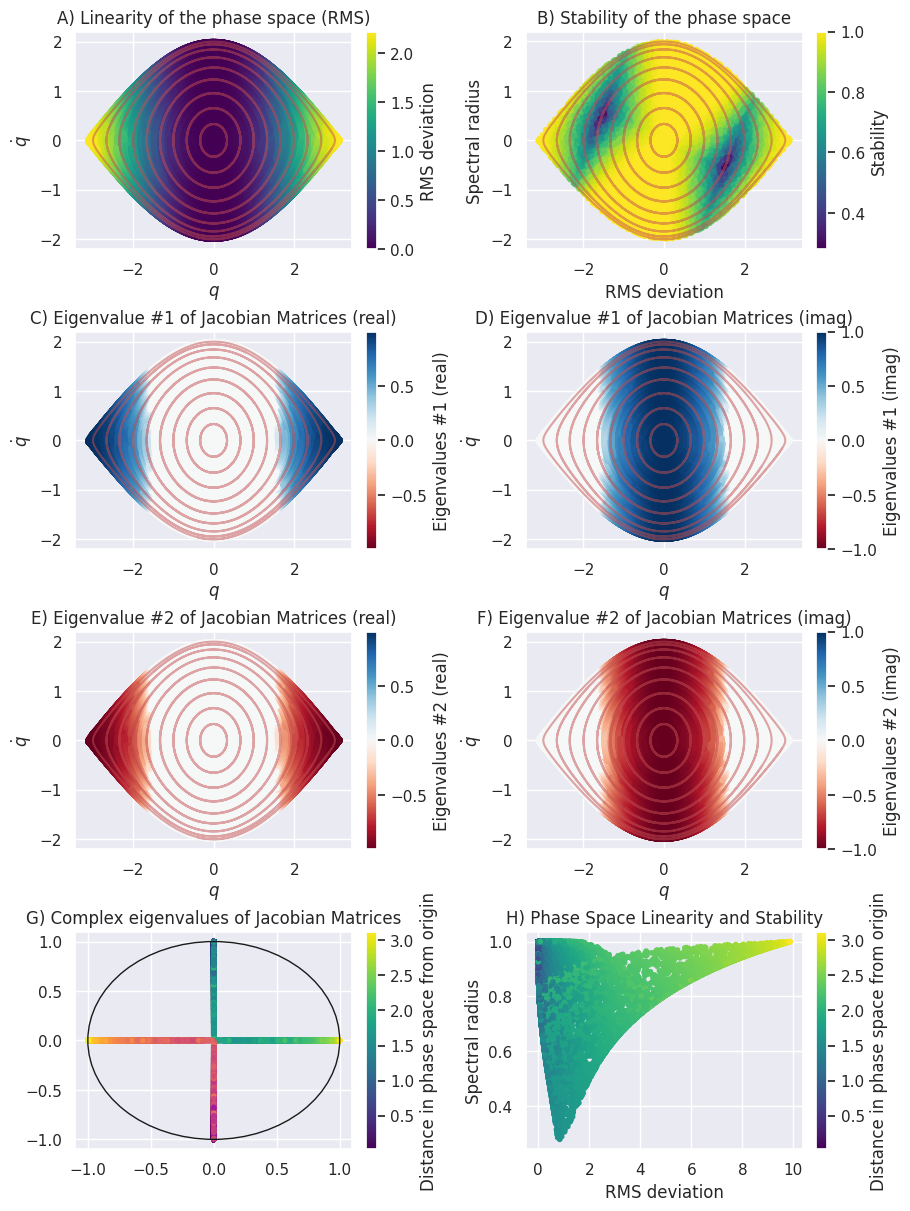

In [25]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 12), constrained_layout=True)
gs = axs[0,0].get_gridspec()
cmap = 'RdBu'

titles = ['A) Linearity of the phase space (RMS)',
          'B) Stability of the phase space',
          'C) Eigenvalue #1 of Jacobian Matrices (real)', 
          'D) Eigenvalue #1 of Jacobian Matrices (imag)',
          'E) Eigenvalue #2 of Jacobian Matrices (real)', 
          'F) Eigenvalue #2 of Jacobian Matrices (imag)',
          'G) Complex eigenvalues of Jacobian Matrices',
          'H) Phase Space Linearity and Stability',
         ]
labels = ['RMS deviation', 'Stability',
          'Eigenvalues #1 (real)','Eigenvalues #1 (imag)',
          'Eigenvalues #2 (real)','Eigenvalues #2 (imag)',
          'Distance in phase space from origin',
          'Distance in phase space from origin'
         ]
scatter_args = [(train_input[:,:,0], train_input[:,:,1], phase_space_linearness),
                (train_input[:,-1,0], train_input[:,-1,1], phase_spectral_radii),
                (train_input[:,:,0], train_input[:,:,1], np.real(phase_eigenvalues_list[:,:,0])),
                (train_input[:,:,0], train_input[:,:,1], np.imag(phase_eigenvalues_list[:,:,0])),
                (train_input[:,:,0], train_input[:,:,1], np.real(phase_eigenvalues_list[:,:,1])),
                (train_input[:,:,0], train_input[:,:,1], np.imag(phase_eigenvalues_list[:,:,1])),
                (phase_eigenvalues_list, phase_eigenvalues_list, distances),
                (np.linalg.norm(phase_space_normalized_deviations[:,-1,:],axis=1), phase_spectral_radii, distances),
               ]
cmaps = ['viridis']*2 + ['RdBu']*4 + [None] + ['viridis']

for ax, title, label, scatter_arg, cmap in zip(axs.flatten(), titles, labels, scatter_args, cmaps):
    if any(option in title for option in ('G')):
        sc = ax.scatter(np.real(scatter_arg[0][:,-1,0]), np.imag(scatter_arg[0][:,-1,0]), c=distances, marker='.', cmap='viridis')
        ax.scatter(np.real(scatter_arg[0][:,-1,1]), np.imag(scatter_arg[0][:,-1,1]), c=distances, marker='.', cmap='plasma')
        circle = plt.Circle((0, 0), 1, color='k', fill=False)
        ax.add_patch(circle)
    else:
        if any(option in title for option in ('A)', 'B)', 'H)')):
            sc = ax.scatter(scatter_arg[0], scatter_arg[1], c=scatter_arg[2], marker='.', cmap=cmap)
        else:
            sc = ax.scatter(scatter_arg[0], scatter_arg[1], c=scatter_arg[2], marker='.', cmap=cmap, vmin=-np.max(np.abs(scatter_arg[2])), vmax=np.max(np.abs(scatter_arg[2])))
    cbar = plt.colorbar(sc, label=label, orientation='vertical')
    if any(option in title for option in ('A)', 'B)', 'C)', 'D)', 'E)', 'F)')):
        for long_traj in long_data_list:
            ax.plot(long_traj[:,-1,0], long_traj[:,-1,1], 'r', alpha=0.5)
        ax.set_xlabel(r'$q$')
        ax.set_ylabel(r'$\dot{q}$')
    if 'Stability' in title:
        ax.set_xlabel('RMS deviation')
        ax.set_ylabel('Spectral radius')        
    ax.set_title(title)

### 1.2) Visualise Lyapunov exponents of the phase space 
To futher examine the state space, we can use Lyapunov exponents to measure of the rate of divergence or convergence of nearby trajectories in a dynamical system (basically seeing how sensitive a system is to small changes in its initial conditions). If the Lyapunov exponents are all negative, then the system is stable and nearby trajectories in phase space converge towards a fixed point, however, if at least one Lyapunov exponent is positive, then the system is chaotic and nearby trajectories in phase space diverge exponentially.

The magnitudes themselves also tell us useful information, magnitudes of the positive Lyapunov exponents show the rate of divergence, meaning that larger magnitudes correspond to faster divergence and more chaotic behavior. The magnitude of the negative Lyapunov exponents indicates the rate of convergence where larger magnitudes correspond to faster convergence and more stable behavior. 

In [26]:
def compute_exponent_at_time(J,d):
    """
    Compute the Lyapunov exponents and updated tangent vectors after one time step using the given Jacobian matrix and
    tangent vectors.

    Parameters:
        J (np.ndarray): The Jacobian matrix of the system at the current time.
        d (np.ndarray): The set of tangent vectors at the current time.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing the Lyapunov exponents and updated tangent vectors at the
        next time step. The Lyapunov exponents are computed from the norms of the orthogonalized tangent vectors using
        the natural logarithm. The tangent vectors are first orthogonalized using Gram-Schmidt orthogonalization, then
        updated by multiplying them with the Jacobian matrix, and finally normalized to have unit length.
    """
    # Orthogonalize the tangent vectors using Gram-Schmidt orthogonalization
    for j in range(d.shape[0]):
        for k in range(j):
            d[j] -= np.dot(d[k], J[j]) * d[k]
        d[j] = d[j] / np.linalg.norm(d[j])
    # Compute the Lyapunov exponents from the norms of the tangent vectors
    lyap_exp = np.log(np.linalg.norm(d, axis=0))
    # Update the tangent vectors
    d = np.dot(J, d)
    # Normalize the tangent vectors
    for j in range(d.shape[0]):
        d[j] = d[j] / np.linalg.norm(d[j])
    return lyap_exp,d


def compute_lyapunov_exponents(system, jacobian, x0, t, epsilon=1e-6):
    """
    Compute the Lyapunov exponents of a dynamical system.

    Parameters
    ----------
    system : function
        A function that computes the derivative of the system.
    jacobian : function
        A function that computes the Jacobian matrix of the system.
    x0 : ndarray
        The initial condition of the system.
    t : ndarray
        The time points at which to compute the Lyapunov exponents.
    epsilon : float, optional
        The perturbation used to compute the tangent vectors.

    Returns
    -------
    x : array_like
        The state trajectory of the system, computed using the initial condition x0.
    lyap_exponents : array_like, shape (T-1, N)
        The Lyapunov exponents of the system at each time step, where T is the number
        of time points and N is the dimension of the system.
    lyap_avg : array_like, shape (N,)
        The average Lyapunov exponents of the system, computed over all time points.
    """

    # Initialize the tangent vectors
    d=np.eye(len(x0))
    
    # Initialize the Lyapunov exponents
    lyap_exponents = np.zeros((len(t)-1,len(x0)))
    
    # Integrate the system using the initial condition x0
    x = odeint(system, x0, t)

    # Loop over all time steps except the first
    for i in range(1, len(t)):
        # Compute exponent
        lyap_exp,d = compute_exponent_at_time(jacobian(system, x[i]),d)
        lyap_exponents[i-1,:] = lyap_exp
    return x,lyap_exponents

In [27]:
# Example usage
x0 = [0,0]
t = np.linspace(0,1,1000)
x, lyap_exponents = compute_lyapunov_exponents(state_system,state_jacobian,x0, t, epsilon=1e-6)
print(np.mean(lyap_exponents,axis=0),lyap_exponents)

To examine the convergence/divergence, we compute average Lyapunov exponents over a space, and create a  vector field plot to show the direction and magnitude of the Lyapunov vector. Specifically, we plot tangent vectors that describes the direction in which nearby trajectories in the phase space diverge or converge exponentially fast. In this, the length of the vector indicates the magnitude of the Lyapunov vector, while the angle between the vector and the horizontal axis indicates the direction of the Lyapunov vector. The vectors are also coloured by the maximum Lyapunov exponent, which represents the degree of chaos or stability.

In [28]:
# As we are computing ODEint for a number of different initial conditions, it is hard to vectorise this code.
# As such, we define a wrapper function for compute_lyapunov_exponents that uses parallel computation
def compute_lyap_exponent_pool(args):
    x0, t, epsilon, system,jacobian  = args
    x, lyap_exponents = compute_lyapunov_exponents(system,jacobian,x0, t, epsilon=1e-6)
    return x,lyap_exponents

Compute the Lyapunov exponents over a grid in the phase space

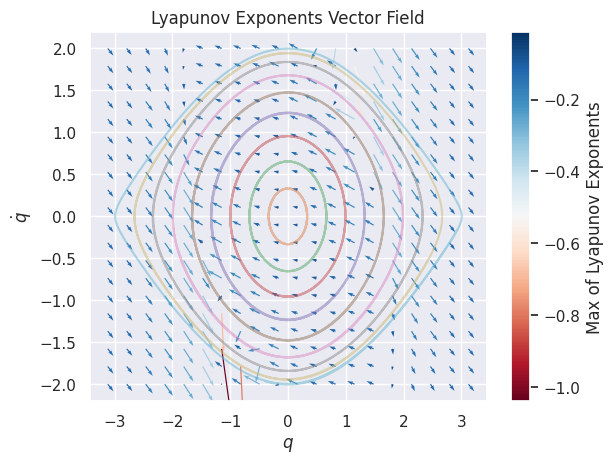

In [29]:
# Define the number of points in the x and y directions
x = np.linspace(np.min(train_input[...,0]),np.max(train_input[...,0]),20)
y = np.linspace(np.min(train_input[...,1]),np.max(train_input[...,1]),20)
num_traj = len(x)*len(y)

# Create a meshgrid of (x,y) points
X, Y = np.meshgrid(x, y)
XY_array = np.array([X.flatten(),Y.flatten()]).T

# Define timesteps
t = np.linspace(0,1,1000)
epsilon = 1e-6

# Compute Lyapunov exponents
# Create the list of conditions
args_list = [(XY_array[i], t, epsilon, state_system, state_jacobian) for i in range(len(XY_array))]

# Use multiprocessing.Pool to parallelize the computation
with Pool() as p:
    outputs = p.map(compute_lyap_exponent_pool, args_list)

# Extract the outputs
Xv = np.array([outputs[i][0][:-1] for i in range(num_traj)])
Xv_lyapunov_exponents = np.array([outputs[i][1] for i in range(num_traj)])
Xv_lyapunov_exponents_avg = np.mean(Xv_lyapunov_exponents,axis=1)
# Find the maximum exponents
max_abs_index = np.argmax(np.abs(Xv_lyapunov_exponents_avg), axis=1)
Xv_lyapunov_exponents_avg_magnitude = Xv_lyapunov_exponents_avg[np.arange(len(Xv_lyapunov_exponents_avg)), max_abs_index]

# Create a quiver plot of the Lyapunov exponents
fig, ax = plt.subplots()
qv = ax.quiver(X, Y, Xv_lyapunov_exponents_avg[:, 0], Xv_lyapunov_exponents_avg[:, 1],
          Xv_lyapunov_exponents_avg_magnitude,cmap='RdBu')
for long_traj in long_data_list:
    ax.plot(long_traj[:,-1,0],long_traj[:,-1,1],alpha=0.5)
ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$\dot{q}$')
ax.set_title('Lyapunov Exponents Vector Field')
cbar = plt.colorbar(qv, label = 'Max of Lyapunov Exponents', orientation='vertical')

## 2) Visualising the latent space

This section examines the learnt latent space to explore if it is correctly linearised, and what interesting dynamics are captured.

### 1.1) Show the stability and linearness of the latent space

Given these functions, the below plot examines the linearity and stability of the learnt system. Specifically, we are looking at the linearness and stableness of the Jacobian of the entire Koopman system, using all eigenfunctions.
    
We can visualise this to see the following:

| Subplot | Description |
|:--------:|:------|
| A)     | **Linearity of the phase space (RMS)** - This subplot shows the RMS deviation between the Jacobian of the linear region, and the state dynamics, plotted onto the phase space, indicating the regions of linearity in the system. In comparision to the figure above, the RMS deviation is now very low in all regions of the phase space. This indicats that the Koopman system learns a linear approximation (in the entire latent space), and is a good approximation of the true Koopman dynamics. Even as we move further to the outer reaches, while non-linearities cause a small increaes in the RMS, this is very small compared to the earlier approach.|
| B)     | **Phase Space Linearity and Stability** - This subplot shows the RMS deviation against the spectral radius of the eigenvalues of the Jacobian, coloured by distance of the trajectories from the origin in the phase space. This shows both linearity and stability in the same graph, where a more linear and stable system will have trajectories closer to the origin and lower spectral radii, while a more nonlinear and unstable system will have trajectories further from the origin and higher spectral radii.|

In [30]:
def compute_latent_linearness(latent_data):
    # Compute the Jacobian of the linear dynamics at each time step for each sample
    jacobians = jacobian_model.predict(latent_data)
    # Compute the deviation from linearity for each sample
    squared_deviation = np.square(np.einsum('ijk,ik->ij', jacobians, latent_data) - latent_data)
    rms_deviation = np.sqrt(np.mean(squared_deviation, axis=1))
    return squared_deviation, jacobians, rms_deviation

In [31]:
# Compute the Jacobians and a linearness measure
latent_space_normalized_deviations,latent_space_jacobians,latent_space_linearness = compute_latent_linearness(train_data_latent)

# Compute the eigenvalues and spectral radii of the Jacobian matrices for the latent space
latent_eigenvalues_list = np.array([np.linalg.eig(jacobian)[0] for jacobian in latent_space_jacobians])
latent_spectral_radii = np.array([np.max(np.abs(eigenvalues)) for eigenvalues in latent_eigenvalues_list])

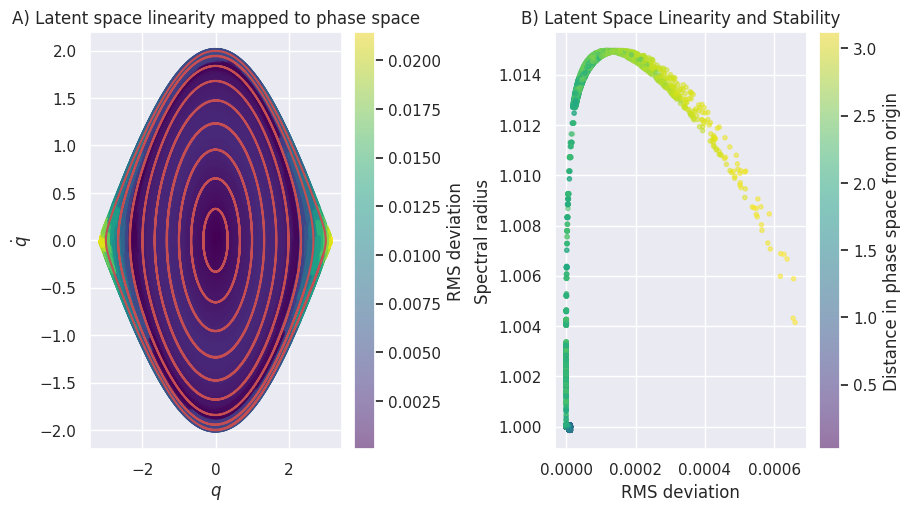

In [32]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 5), constrained_layout=True)
gs = axs[0].get_gridspec()

# Define the titles and labels for each subplot
titles = ['A) Latent space linearity mapped to phase space', 'B) Latent Space Linearity and Stability']
labels = ['RMS deviation', 'Distance in phase space from origin']

# Define the data to be plotted for each subplot, as well as the color value to be used for the scatter plots
scatter_args = [(train_input[:,:, 0], train_input[:,:, 1], np.tile(latent_space_linearness,(DATA_TIMESTEPS,1)).T),
                (np.linalg.norm(latent_space_normalized_deviations,axis=1), latent_spectral_radii, distances)]

# Iterate over the subplots and their corresponding data
for ax, title, label, scatter_arg in zip(axs.flatten(), titles, labels, scatter_args):
    # Scatter the data for each plot
    sc = ax.scatter(scatter_arg[0],scatter_arg[1],c=scatter_arg[2], marker='.',cmap = 'viridis', alpha=0.5)
    cbar = plt.colorbar(sc, label = label, orientation='vertical')
    
    # For subplots with titles containing 'A)', 'B)', 'E)', or 'F)', overlay a red line plot showing the trajectory of the system
    if 'A)' in title:
        for long_traj in long_data_list:
            ax.plot(long_traj[:,-1,0],long_traj[:,-1,1],'r')
        ax.set_xlabel(r'$q$')
        ax.set_ylabel(r'$\dot{q}$')
    
    # For subplots with titles containing 'Stability', set the x and y axis labels to 'RMS deviation' and 'Spectral radius', respectively
    if 'Stability' in title:
        ax.set_xlabel('RMS deviation')
        ax.set_ylabel('Spectral radius')        
    
    ax.set_title(title)

We can also plot the stability of each of the individual eigenfunctions. If the model has learned the latent space correctly and linearized the dynamics, the eigenvalues of the Jacobian of the eigenfunctions should show stability.

In [33]:
# Extract the Jacobian of each complex eigenfunction pair (ignoring between eigenfunction derivatives)
def extract_Eigenfuntion_Jacobians(Jacobians):
    jacobians_by_eigenfunction = []
    for i in range(par['num complex']):
        jacobian_pair = Jacobians[..., 2*i:2*i+2, 2*i:2*i+2]
        jacobians_by_eigenfunction.append(jacobian_pair)
    return jacobians_by_eigenfunction

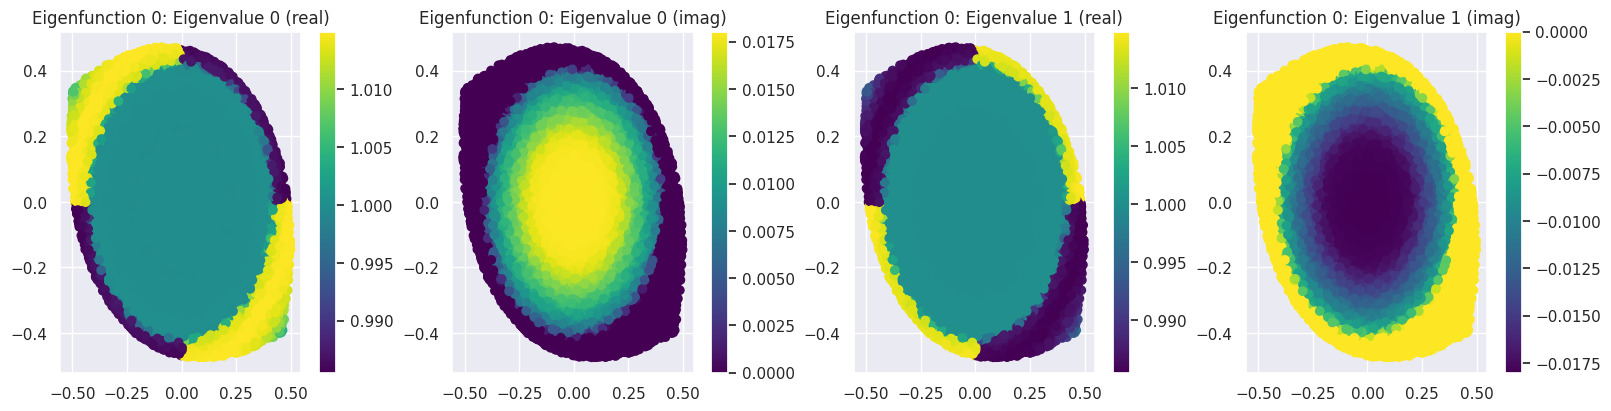

In [35]:
fig, axs = plt.subplots(par['num complex'], 4, figsize=(16, par['num complex']*4), constrained_layout=True)

jacobians_by_eigenfunction = extract_Eigenfuntion_Jacobians(latent_space_jacobians)
eigs_of_each_jacobian_by_eigenfunction = [np.linalg.eigvals(x) for x in jacobians_by_eigenfunction]

i = 0
for row,eigfn_num in enumerate(range(0,2*par['num complex'],2)):
    for eigenvalue_num in range(2):
        for color_index, color in enumerate(zip([np.real(eigs_of_each_jacobian_by_eigenfunction[row][:,eigenvalue_num]),
                         np.imag(eigs_of_each_jacobian_by_eigenfunction[row][:,eigenvalue_num])])):
            sc = axs.flatten()[i].scatter(train_data_latent[:,eigfn_num],train_data_latent[:,eigfn_num+1],
                                    c=color,cmap = 'viridis')
            axs.flatten()[i].set_title('Eigenfunction {}: Eigenvalue {} ({})'.format(row,eigenvalue_num, 'real' if color_index==0 else 'imag'))
            cbar = plt.colorbar(sc, orientation='vertical')    
            i+=1

### 1.3) Visualise behaviours of the phase space in the latent space 

It is also interesting to map observed behaviours in the phase space, to graphs of the latent space, to see how the latent structures are stabilising the non-linear phase space:

|                | **Description** |  
|:--------:|:------|
| **Linearity**     | In this, it is seen that the regions of low linearity in the phase space map onto the outer regions of the first eigenfunctions |  
| **Stability**     | The regions of instability in the phase space correspond to the thinning component of eigenfunction 2, while seems unrelated to eigenfunction 1. This might be due to the fact that eigenfunction 1 is capturing general oscillation, and eigenfunction 2 is capturing the non-linearity of higher angles | 
| **Chaos** | Lyapunov exponents computed from the phase space are plotted onto corresponding latent space points. This helps visualize how the stability and chaotic properties are transformed into the learnt latent space, and potentially reveal interesting patterns or relationships between the two spaces. A note of caution, these are not the Lyapunov exponents of the latent space, and the relationship between the original and latent spaces can be complex and unintuitive.|


In [36]:
# Compute Lyapunov exponents of some samples from the training data to visualise

# Create the list of conditions
t = np.linspace(0,1,1000)
num_traj = 100
args_list = [(train_input[i,-1], t, epsilon, state_system, state_jacobian) for i in range(num_traj)]

# Use multiprocessing.Pool to parallelize the computation
with Pool() as p:
    outputs = p.map(compute_lyap_exponent_pool, args_list)

# Extract the outputs
Xv = np.array([outputs[i][0][:-1] for i in range(num_traj)])
Xv_lyapunov_exponents = np.array([outputs[i][1] for i in range(num_traj)])
Xv_lyapunov_exponents_avg = np.mean(Xv_lyapunov_exponents,axis=1)
# Find the maximum exponents
max_abs_index = np.argmax(np.abs(Xv_lyapunov_exponents_avg), axis=1)
Xv_lyapunov_exponents_avg_magnitude = Xv_lyapunov_exponents_avg[np.arange(len(Xv_lyapunov_exponents_avg)), max_abs_index]

/tmp/ipykernel_28161/1059379622.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(scatter_arg[0], scatter_arg[1],c=scatter_arg[2],marker='.',cmap = 'viridis',alpha=0.01)


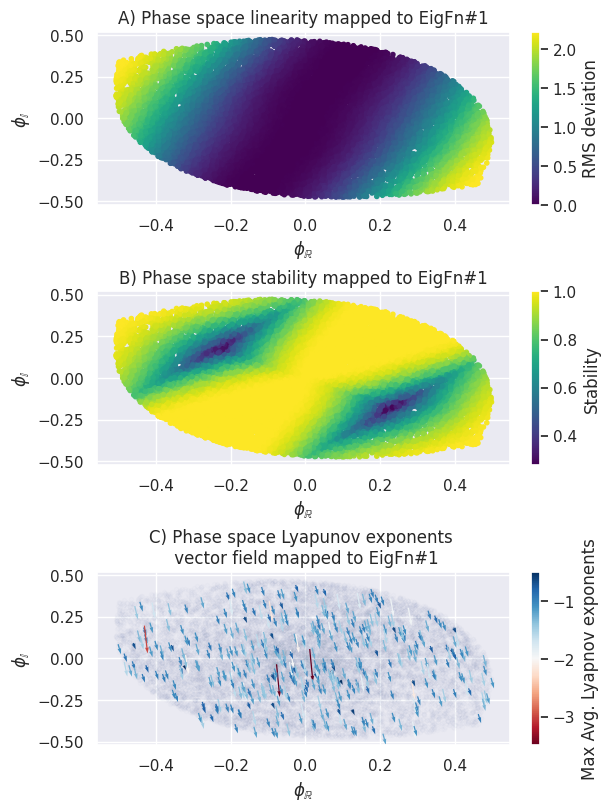

In [93]:
fig, axs = plt.subplots(nrows=3, ncols=par['num complex'], figsize=(6, 8), constrained_layout=True)

# Define the titles and labels for each subplot
titles_linear = ['{}) Phase space linearity mapped to EigFn#{}'.format(chr(64+i), i) for i in range(1,par['num complex']+1)]
titles_stability = ['{}) Phase space stability mapped to EigFn#{}'.format(chr(64+par['num complex']+i), i) for i in range(1,par['num complex']+1)]
titles_lyapunov = ['{}) Phase space Lyapunov exponents \n vector field mapped to EigFn#{}'.format(chr(64+2*par['num complex']+i), i) for i in range(1,par['num complex']+1)]
titles = titles_linear+titles_stability+titles_lyapunov
         
labels = [item for item in ['RMS deviation','Stability','Max Avg. Lyapnov exponents'] for _ in range(par['num complex'])]

# Define the data to be plotted for each subplot, as well as the color value to be used for the scatter plots
scatter_args = [(train_data_latent[:,i*2], train_data_latent[:,i*2+1], value) for value in [phase_space_linearness[:,-1], phase_spectral_radii, None] for i in range(par['num complex'])]        
        
# Iterate over the subplots and their corresponding data
for ax, title, label, scatter_arg in zip(axs.flatten(), titles, labels, scatter_args):   
    if 'Lyapunov' in title:
        ax.scatter(scatter_arg[0], scatter_arg[1],c=scatter_arg[2],marker='.',cmap = 'viridis',alpha=0.01)
        sc = ax.quiver(scatter_arg[0][:len(Xv_lyapunov_exponents_avg_magnitude)],
                       scatter_arg[1][:len(Xv_lyapunov_exponents_avg_magnitude)],
                       Xv_lyapunov_exponents_avg[:, 0], Xv_lyapunov_exponents_avg[:, 1],
                  Xv_lyapunov_exponents_avg_magnitude,cmap='RdBu')
    else:
        sc = ax.scatter(scatter_arg[0],scatter_arg[1],c=scatter_arg[2], marker='.',cmap = 'viridis')   
    cbar = plt.colorbar(sc, label = label, orientation='vertical')     
    ax.set_title(title)
    ax.set_xlabel(r'$\phi_\mathbb{R}$')
    ax.set_ylabel(r'$\phi_\mathbb{I}$')

### 1.2) Visualise Lyapunov exponents of the latent space

Like the phase space, we can examine the rate of divergence or convergence of nearby trajectories in the latent system. This analysis of the latent space using Lyapunov exponents can provide insight into the stability and predictability of the system. For this example, only one eigenfunction is shown due to the computational cost of running this for all eigenfunctions, but the code can be easily modified.

Additionally, due to the fact that predicting on the Koopman model inside the Lyapunov computation is very slow, we precompute Jacobians and timeseries from initial conditions beforehand.

In [76]:
# Get the list of starting points to evaluate at
grid_size = 20
x = []
for i in range(2*par['num complex']):
    x.append(np.linspace(np.min(train_data_latent[...,i]), np.max(train_data_latent[...,i]), grid_size))
Xv_latent_grid = np.meshgrid(*x)
Xv_latent_grid = np.array([x.flatten() for x in Xv_latent_grid]).T

num_traj = Xv_latent_grid.shape[0]
t = np.linspace(0,1,1000)

In [77]:
# Compute 1000 timesteps into the future
Xv_latent_grid_list=[]
for i in range(len(t)):
    Xv_latent_grid = custom_Knet.predict(Xv_latent_grid)[1]
    Xv_latent_grid_list.append(Xv_latent_grid)
Xv_latent_grid_list = np.array(Xv_latent_grid_list)
Xv_latent_grid_shape = Xv_latent_grid_list.shape

In [78]:
# Compute the Jacobians
train_data_latent_KGx1000_jacobians = jacobian_model.predict(np.reshape(Xv_latent_grid_list,(Xv_latent_grid_list.shape[0]*Xv_latent_grid_list.shape[1],Xv_latent_grid_list.shape[2])))
train_data_latent_KGx1000_jacobians = np.reshape(train_data_latent_KGx1000_jacobians,Xv_latent_grid_shape+(2*par['num complex'],))
# Get the Jacobians for each eigenfunction
jacobians_by_eigenfunction_KGx1000 = extract_Eigenfuntion_Jacobians(train_data_latent_KGx1000_jacobians)

In [79]:
def compute_lyap_exponent_one_sample(jacobian,t):
    # Initialize the tangent vectors
    d=np.eye(jacobian.shape[-1])

    # Initialize the sum of the Lyapunov exponents
    lyap_sum = 0
    lyap_exponents = np.zeros((len(t)-1,jacobian.shape[-1]))

    # Loop over all time steps except the first
    for i in range(1, len(t)):
        lyap_exp, d =compute_exponent_at_time (jacobian[i],d)
        lyap_exponents[i-1,:] = lyap_exp
    return lyap_exponents

In [80]:
# Compute Lyapunov exponents
def compute_lyap_exponent_pool_latent(args):
    jacobian,t  = args
    lyap_exponents = compute_lyap_exponent_one_sample(jacobian, t)
    return lyap_exponents

# Create the list of conditions
eigenfunction_index = 0
args_list = [(jacobians_by_eigenfunction_KGx1000[eigenfunction_index][:,sample],t ) for sample in range(num_traj)]

# Use multiprocessing.Pool to parallelize the computation
with Pool() as p:
    outputs = p.map(compute_lyap_exponent_pool_latent, args_list)

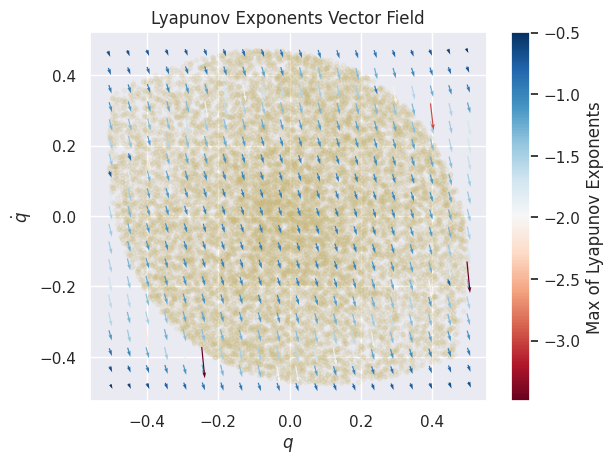

In [88]:
# Extract the outputs
Xv_lyapunov_exponents = np.array([outputs[i] for i in range(num_traj)])
Xv_lyapunov_exponents_avg = np.mean(Xv_lyapunov_exponents,axis=1)
# Find the maximum exponents
max_abs_index = np.argmax(np.abs(Xv_lyapunov_exponents_avg), axis=1)
Xv_lyapunov_exponents_avg_magnitude = Xv_lyapunov_exponents_avg[np.arange(len(Xv_lyapunov_exponents_avg)), max_abs_index]

# Create a quiver plot of the Lyapunov exponents
fig, ax = plt.subplots()
ax.scatter(train_data_latent[:,0],train_data_latent[:,1],marker='.',alpha=0.1,color='y')
qv = ax.quiver(Xv_latent_grid_list[0,:,0], Xv_latent_grid_list[0,:,1], Xv_lyapunov_exponents_avg[:, 0], Xv_lyapunov_exponents_avg[:, 1],
          Xv_lyapunov_exponents_avg_magnitude,cmap='RdBu')
ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$\dot{q}$')
ax.set_title('Lyapunov Exponents Vector Field')
cbar = plt.colorbar(qv, label = 'Max of Lyapunov Exponents', orientation='vertical')

# 3. Finding the number of eigenfunctions

To determine the number of eigenfunctions needed to accurately capture the dominant modes of a system's dynamics, can use the eigenvalue spectrum. This gives a measure of the relative importance of each eigenfunction, where a significant drop or gap in the magnitude of the eigenvalues can indicate a separation between the dominant and higher-order modes, allowing you to choose the number of eigenfunctions needed to capture the dominant modes accurately.

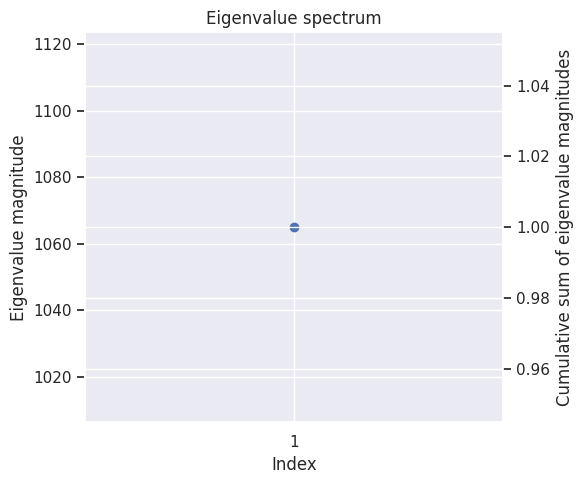

In [69]:
def compute_K_eigenvalue_spectrum(train_data_latent, train_data_eigenvalues, par):
    """
    Computes the eigenvalue spectrum of the Koopman operator matrix using the given eigenfunctions and eigenvalues.

    Args:
        train_data_latent (numpy.ndarray): Matrix of eigenfunctions, with shape (n_samples, 2*num_complex + num_real).
        train_data_eigenvalues (numpy.ndarray): Matrix of eigenvalues, with shape (n_samples, 2*num_complex + num_real).
        par (dict): Dictionary of parameters.

    Returns:
        K (numpy.ndarray): Koopman operator matrix.
        eigenvalues (numpy.ndarray): Eigenvalues of the Koopman operator matrix.
        eigenvalue_spectrum (numpy.ndarray): Array of absolute values of the eigenvalues of the Koopman operator matrix.
    """
    num_complex = int(par['num complex'])
    num_real = int(par['num real'])
    n_samples = train_data_latent.shape[0]

    # Extract complex eigenvectors and eigenvalues
    eigenvectors_complex = train_data_latent[:, :2*num_complex]
    eigenvalues_complex = train_data_eigenvalues[:, :2*num_complex]
    eigenvectors_complex = eigenvectors_complex[:, ::2] + 1j * eigenvectors_complex[:, 1::2]
    eigenvalues_complex = eigenvalues_complex[:, ::2] + 1j * eigenvalues_complex[:, 1::2]

    if num_real > 0:
        # Extract real eigenvectors and eigenvalues and concatenate with complex ones
        eigenvectors_real = train_data_latent[:, 2*num_complex:]
        eigenvalues_real = train_data_eigenvalues[:, 2*num_complex:]
        eigenvectors = np.concatenate([eigenvectors_complex, np.reshape(eigenvectors_real, (n_samples, 1))], axis=1)
        eigenvalues = np.concatenate([eigenvalues_complex, np.reshape(eigenvalues_real, (n_samples, 1))], axis=1)
    else:
        eigenvectors = eigenvectors_complex
        eigenvalues = eigenvalues_complex

    # Initialize the Koopman operator matrix
    K = np.zeros((num_complex + num_real, num_complex + num_real), dtype=np.complex128)

    # Construct the Koopman operator matrix using the eigenvalues and eigenvectors
    for i in range(n_samples):
        K += eigenvalues[i, :] * np.outer(eigenvectors[i, :], np.conj(eigenvectors[i, :]))

    # Compute the eigenvalues of the Koopman operator matrix
    eigenvalues, _ = np.linalg.eig(K)

    # Return the Koopman operator matrix, eigenvalues and eigenvalue spectrum
    eigenvalue_spectrum = np.abs(eigenvalues)
    return K, eigenvalues, eigenvalue_spectrum


K,eigenvalues, eigenvalue_spectrum = compute_K_eigenvalue_spectrum(train_data_latent, train_data_eigenvalues,par)

fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.scatter(range(1,len(eigenvalue_spectrum)+1),eigenvalue_spectrum)
ax.set_xlabel('Index')
ax.set_ylabel('Eigenvalue magnitude')
ax.set_title('Eigenvalue spectrum')
ax.set_xticks(range(1,len(eigenvalue_spectrum)+1))
ax.set_xticklabels(range(1,len(eigenvalue_spectrum)+1))

# create a secondary y-axis
ax2 = ax.twinx()
ax2.plot(range(1,len(eigenvalue_spectrum)+1),np.cumsum(eigenvalue_spectrum) / np.sum(eigenvalue_spectrum), color='red')
ax2.set_ylabel('Cumulative sum of eigenvalue magnitudes')

fig.tight_layout()

# Other interesting dynamics


## 1) Linear systems

Consider the linear dynamical system:

$\mathbf{\dot{x}} = [x_1,-x_0]$

The dynamical system describes a simple harmonic oscillator in two dimensions, with the position of the object represented by the vector $\mathbf{x}=[x_0,x_1]$ and the velocity represented by the vector $\mathbf{\dot{x}} = [x_1,-x_0]$. This system exhibits periodic motion around the origin, with the trajectory of the object tracing out a circle. The properties of this system include the conservation of energy and angular momentum, and the existence of stable and unstable fixed points at the origin and at points on the circle with non-zero radius.

To capture the periodic motion of this system, we can use complex exponentials as eigenfunctions, and since the system has one degree of freedom (clock-wise rotation), we will need one eigenfunction to fully capture its dynamics. The real part of this eigenfunction describes motion along the x-axis of the latent space, while the imaginary part describes motion along the y-axis.

Since this eigenvalue is complex, it has a non-zero imaginary part. The real part of the eigenvalue is 0 (as there is no growth/decay), while the imaginary part is 1 (as the frequency is constant).

This system can be modelled with the Duffing oscillator with $\alpha=-1$, and all other parameters being zero.

In the context of learning eigenfunctions, as this is a linear system the eigenfunctions are just a rotation coordinate transformation, without scaling or shearing.

![image info](./figs/linear_system.png)

## 2) Pendulum with damping

In another pendulum example, we can also analyse the dynamics with friction, where friction $mu=0.1$.

In this, it is seen that after learning, the real component of the eigenvalue ($\mu$, in subplot H)) is shown to be constant negative, due to the damping introduced by the friction. This negative real component captures the decay in the amplitude of the system over time, which is caused by the energy dissipation due to the friction.

Specifically, the negative real component of the eigenvalue indicates that the amplitude of the system will decrease over time, eventually approaching zero as energy is continuously dissipated. The negative real component of the eigenvalue captures this damping effect and allows us to model the decay in the amplitude of the system over time.

In contrast to the standard case with no damping, where the real component of the eigenvalue is zero, the introduction of friction leads to a negative real component of the eigenvalue, indicating that the system's behavior is now dominated by the damping effect of the friction. This highlights the importance of considering the effects of damping when analyzing the dynamics of a physical system, as it can significantly affect the behavior of the system over time.

Please note that the notation $mu$ here denotes friction, and the symbol $\mu$ denotes the real value of the complex eigenfunction, and should not be mixed up.

![image info](./figs/pendulum_damping_complex1.png)

## 3) Multiple complex eigenfunctions

The standard pendulum dynamics analysis (with $mu=0$ here) can be extended by increasing the number of complex eigenfunctions from one, to two. This explores additional behaviours not captured by the first eigenfunction. 

First complex eigenfunction:

![image info](./figs/pendulum_complex2_num1.png)

Second complex eigenfunction:

![image info](./figs/pendulum_complex2_num2.png)


In this, it is seen that while the first eigenfunction still linearizes the phase-space in polar coordinates and captures oscillation as expected, the second eigenfunction appears almost orthogonal to both the phase space and the first eigenfunction latent space. This suggests that the second eigenfunction captures additional information about the pendulum system that is not captured by the first eigenfunction. Specifically, the second eigenfunction appears to capture additional non-linear behavior in the system not captured by the first eigenfunction.

Specifically, in (C) it is seen that the second eigenfunction acts on different regions in the phase space, specifically, it maps orbits with starting angles between $q=0$ to $q=2.3$ to similar radius orbits along a cylinder (B), while orbits with higher initial starting angles $q>2.6$ are mapped to orbits with varying radii non-linearly. This implies that there is something similar between the lower angles but not for higher angles. From looking at the real eigenvalues (H), it is seen that the system exhibts stable behaviour (negative eigenvalues) in the lower angles, but slight unstable behaviour (positive eigenvalues) for the higher angles. As the angle approaches $\pi$, the system becomes increasingly unstable, and the second eigenfunction may be capturing the non-linear dynamics associated with this instability and chaos. Specifically, this eigenfunction is capturing changes around inversion, chaos/complexity, or non-linearities in the sin function, and is useful for predicting the behavior of the system at high angles or under chaotic conditions.

To explore this in more detail, a vector field of Lyapunov exponents is shown. In this, it is seen that this seperation region corresponds to the boundary region where the vector's change orientation, indicating a critial point. 

![image info](./figs/pendulum_complex2_lyapunov_field.png)

Note, this is not specific to the case with no damping. In the case with $mu>0$, we can see (as in the previous experiment), that the real component of the first eigenvalue captures the decay, and that the second eigenfunction still captures this non-linearity in radius. This suggests the second eigenfunction is not specifically targeting chaos (as adding damping should reduce chaotic effects), but it could still reflect properties that lead to more complex dynamics at higher energies. 

In this, it is seen that eigenfunctions are learning distinct properties of the system rather than just one dominant property, each revealing unique information about the system.

## 3) Control

This notebook also works for systems under control (see  https://arxiv.org/pdf/2210.07563.pdf).

To experiment with this, please change the control signal option in 'Generate pendulum data.ipynb' to 'pd' and change N = 300, and set 'num_control=1' in this notebook.


![image info](./figs/pendulum_pd_controller.png)